In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from glob import glob
import os
import tensorflow as tf
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam, SGD


In [3]:
BATCH_SIZE = 8 # Pretty self-explanatory :)

NUM_PICS = 8 # Number of pictures to display from a batch while visualizing. 
             # It must be less than or equal to the BATCH_SIZE.

## Preparing The Dataset

In [4]:
def preprocess(path):
  image = tf.io.read_file(path)

  image = tf.io.decode_jpeg(image)

  image = tf.image.resize(image, (224,224))

  image = image/255
  return image

In [5]:
####################################################################################
################################## Train Dataset ###################################
####################################################################################

# Create a train dataset for the images containing car plates.

# Images only dataset
train_images_paths_with_plate = sorted(glob(os.path.join('/content','drive','MyDrive','car_tag_data','data','train_data','with_plate','*.jpg')))
train_images_dataset_with_plate = tf.data.Dataset.from_tensor_slices(train_images_paths_with_plate)
train_images_dataset_with_plate = train_images_dataset_with_plate.map(preprocess)

# Label dataset for with plate images in the dataset
train_labels_path = '/content/drive/MyDrive/car_tag_data/data/train_label'
train_labels_list = []
for filename in sorted(os.listdir(train_labels_path)):
    f = open(os.path.join(train_labels_path, filename))
    data = json.load(f)
    img_W, img_H = data['images'][0]['width'],data['images'][0]['height']
    normal_train_labels_list = [float(number/img_W) if idx%2==0 else float(number/img_H) for idx, number in enumerate(data['annotations'][0]['bbox'])]
    normal_train_labels_list.insert(0, 1)
    train_labels_list.append(normal_train_labels_list)

train_labels_dataset_with_plate = tf.data.Dataset.from_tensor_slices(train_labels_list)
# Zip together
train_dataset_with_plate = tf.data.Dataset.zip((train_images_dataset_with_plate, train_labels_dataset_with_plate))

# Create a train dataset for the images not containing car plates.

# Images only dataset
train_images_paths_no_plate = sorted(glob(os.path.join('/content','drive','MyDrive','car_tag_data','data','train_data','no_plate','*.jpg')))
train_images_dataset_no_plate = tf.data.Dataset.from_tensor_slices(train_images_paths_no_plate)
train_images_dataset_no_plate = train_images_dataset_no_plate.map(preprocess)

# Label dataset for no plate images in the dataset
train_labels_dataset_no_plate = tf.data.Dataset.from_tensor_slices(tf.zeros(shape=(len(train_images_paths_no_plate), 5)))
# Zip together
train_dataset_no_plate = tf.data.Dataset.zip((train_images_dataset_no_plate, train_labels_dataset_no_plate))

# concatenate both with plate and no plate datasets together
train_data = train_dataset_with_plate.concatenate(train_dataset_no_plate)

# shuffle and batch the data
train_data = train_data.shuffle(len(train_data))
train_data_batched = train_data.batch(BATCH_SIZE)

####################################################################################
################################## Test Dataset ####################################
####################################################################################

# Create a test dataset for the images containing car plates.

# Images only dataset
test_images_paths_with_plate = sorted(glob(os.path.join('/content','drive','MyDrive','car_tag_data','data','test_data','with_plate','*.jpg')))
test_images_dataset_with_plate = tf.data.Dataset.from_tensor_slices(test_images_paths_with_plate)
test_images_dataset_with_plate = test_images_dataset_with_plate.map(preprocess)

# Label dataset for with plate images in the dataset
test_labels_path = '/content/drive/MyDrive/car_tag_data/data/test_label'
test_labels_list = []
for filename in sorted(os.listdir(test_labels_path)):
    f = open(os.path.join(test_labels_path, filename))
    data = json.load(f)
    img_W, img_H = data['images'][0]['width'],data['images'][0]['height']
    normal_test_labels_list = [float(number/img_W) if idx%2==0 else float(number/img_H) for idx, number in enumerate(data['annotations'][0]['bbox'])]
    normal_test_labels_list.insert(0, 1)
    test_labels_list.append(normal_test_labels_list)

test_labels_dataset_with_plate = tf.data.Dataset.from_tensor_slices(test_labels_list)
# Zip together
test_dataset_with_plate = tf.data.Dataset.zip((test_images_dataset_with_plate, test_labels_dataset_with_plate))

# Create a test dataset for the images not containing car plates.

# Images only dataset
test_images_paths_no_plate = sorted(glob(os.path.join('/content','drive','MyDrive','car_tag_data','data','test_data','no_plate','*.jpg')))
test_images_dataset_no_plate = tf.data.Dataset.from_tensor_slices(test_images_paths_no_plate)
test_images_dataset_no_plate = test_images_dataset_no_plate.map(preprocess)

# Label for no_plate images in the dataset
test_labels_dataset_no_plate = tf.data.Dataset.from_tensor_slices(tf.zeros(shape=(len(test_images_paths_no_plate), 5)))
# Zip together
test_dataset_no_plate = tf.data.Dataset.zip((test_images_dataset_no_plate, test_labels_dataset_no_plate))

# Concatenate both with plate and no plate datasets together
test_data = test_dataset_with_plate.concatenate(test_dataset_no_plate)

# Shuffle and batch the data
test_data = test_data.shuffle(len(test_data))
test_data_batched = test_data.batch(BATCH_SIZE)



In [ ]:
len(train_data),len(test_data)

## Visualize Data

visualizing the images with the corresponding labels to see if they have the right labels.

In [7]:
iterator = iter(train_data_batched)

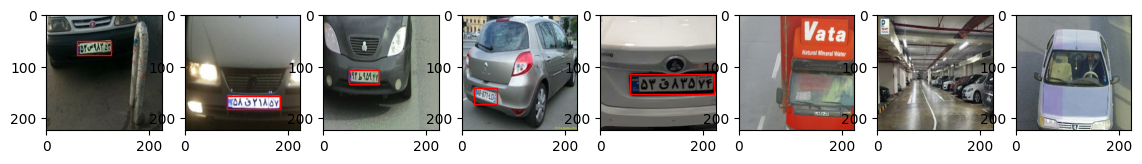

In [8]:
i = next(iterator)
fig, ax = plt.subplots(1,NUM_PICS,figsize=(14,14))

for idx, img in enumerate(i[0]):
  label = i[1][idx]

  if tf.round(label[0]):
    rect = plt.Rectangle((label[1] * 224 ,label[2]*224), label[3]*224,label[4]*224,
                          linewidth = 1,
                          edgecolor = 'r', 
                          facecolor = 'none')
    ax[idx].imshow(img)
    ax[idx].add_patch(rect)
  else:
    ax[idx].imshow(img)

  if idx == NUM_PICS-1:
    break

## Create And Train The Model

In [9]:
# There are 3 models here you can create whichever you want by calling the corresponding function:
# - create_model
# - create_model_
# - create_model__

def create_model(input_shape, layers_to_unfreeze=None, freeze_bn=True, w_initializer='glorot_normal'): # (224,224,3)
  # Use a pretrained model(MobileNet in our case) for feature extraction.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

  # Freeze the layers of the pretrained model.
  for layer in base_model.layers:
      layer.trainable = False
  
  # How many layers of the pretrained model do you need to unfreeze?
  if layers_to_unfreeze:
    for i in range(layers_to_unfreeze):
      idx = -1*i-1
      base_model.layers[idx].trainable = True

  # Freeze the batch_nomalization layers if freeze_bn is set to True
  if freeze_bn:
    for layer in base_model.layers:
      if 'bn' in layer.name:
        layer.trainable = False
 
  x = Conv2D(256,(1,1), padding = 'same', activation = 'relu',kernel_initializer = w_initializer)(base_model.output)
  x = Flatten()(x)
  x = Dense(256 ,activation = 'relu', kernel_initializer = w_initializer)(x)
  x = Dense(128, activation = 'relu',kernel_initializer = w_initializer)(x)
  output = Dense(5, activation = 'sigmoid')(x)
  model = tf.keras.models.Model(inputs = base_model.input, outputs = output)
  return model


def create_model_(input_shape, layers_to_unfreeze=None, freeze_bn=True, w_initializer='glorot_normal'): # (224,224,3)
  # Use a pretrained model(MobileNet in our case) for feature extraction.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

  # Freeze the layers of the pretrained model.
  for layer in base_model.layers:
      layer.trainable = False

  # How many layers of the pretrained model do you need to unfreeze?
  if layers_to_unfreeze:
    for i in range(layers_to_unfreeze):
      idx = -1*i-1
      base_model.layers[idx].trainable = True

  # Freeze the batch_nomalization layers if freeze_bn is set to True
  if freeze_bn:
    for layer in base_model.layers:
      if 'bn' in layer.name:
        layer.trainable = False

  x = Conv2D(512,(1,1), padding = 'same', activation = 'relu',kernel_initializer = w_initializer)(base_model.output)
  x = Conv2D(128,(1,1), padding = 'same', activation = 'relu',kernel_initializer = w_initializer)(x)
  x = Conv2D(5,(7,7), padding = 'valid', activation = 'sigmoid',kernel_initializer = w_initializer)(x)
  output = Flatten()(x)
  model = tf.keras.models.Model(inputs = base_model.input, outputs = output)
  return model


def create_model__(input_shape, layers_to_unfreeze=None, freeze_bn=True, w_initializer='glorot_normal'): # (224,224,3)
  # Use a pretrained model(MobileNet in our case) for feature extraction.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

  # Freeze the layers of the pretrained model.
  for layer in base_model.layers:
      layer.trainable = False
  
  # How many layers of the pretrained model do you need to unfreeze?
  if layers_to_unfreeze:
    for i in range(layers_to_unfreeze):
      idx = -1*i-1
      base_model.layers[idx].trainable = True

  # Freeze the batch_nomalization layers if freeze_bn is set to True
  if freeze_bn:
    for layer in base_model.layers:
      if 'bn' in layer.name:
        layer.trainable = False

  x = GlobalAveragePooling2D()(base_model.output)
  x = Dense(256 ,activation = 'relu', kernel_initializer = w_initializer)(x)
  x = Dense(128, activation = 'relu',kernel_initializer = w_initializer)(x)
  output = Dense(5, activation = 'sigmoid')(x)
  model = tf.keras.models.Model(inputs = base_model.input, outputs = output)
  return model

In [10]:
# Create a custom loss function
def loss_fn(y, y_hat):
  bce1 = binary_crossentropy(y[:,1:],y_hat[:,1:])
  bce2 = binary_crossentropy(y[:,0],y_hat[:,0])
  return y[:,0] * bce1 + 0.05* bce2

In [23]:
model = create_model_(input_shape=(224,224,3), layers_to_unfreeze=3, freeze_bn=True, w_initializer='glorot_uniform')
model.compile(loss=loss_fn, optimizer=Adam(learning_rate=.001))

In [ ]:
model.summary()

In [ ]:
history = model.fit(train_data_batched, batch_size=BATCH_SIZE, validation_data=test_data_batched, epochs=10)

## Loss curves

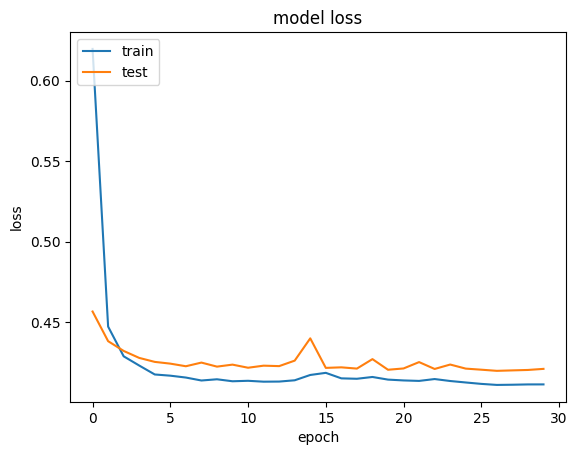

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Visualize predictions on trainset


In [33]:
iterator_ = iter(train_data_batched)

1/1 [==============================] - 0s 73ms/step
0.99999547
1/1 [==============================] - 0s 70ms/step
0.9999943
1/1 [==============================] - 0s 83ms/step
0.9999965
1/1 [==============================] - 0s 70ms/step
0.006048454
1/1 [==============================] - 0s 76ms/step
0.0026328608
1/1 [==============================] - 0s 77ms/step
0.9999918
1/1 [==============================] - 0s 77ms/step
0.99999416
1/1 [==============================] - 0s 81ms/step
0.0016316778


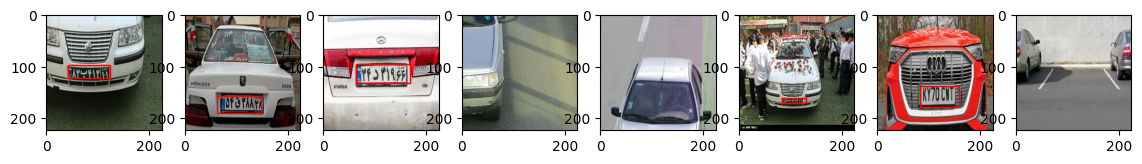

In [36]:
i_ = next(iterator_)
fig, ax = plt.subplots(1,NUM_PICS,figsize=(14,14))

for idx, img in enumerate(i_[0]):
  label = model.predict(tf.expand_dims(img, 0))
  if tf.round(label[0][0]):
    print(label[0][0])
    rect = plt.Rectangle((label[0][1] * 224 ,label[0][2]*224), label[0][3]*224,label[0][4]*224,
                          linewidth = 1,
                          edgecolor = 'r', 
                          facecolor = 'none')
    ax[idx].imshow(img)
    ax[idx].add_patch(rect)
  else:
    print(label[0][0])
    ax[idx].imshow(img)

  if idx == NUM_PICS-1:
    break

## Visualize predictions on testset


In [37]:
iterator__ = iter(test_data_batched)

1/1 [==============================] - 0s 74ms/step
0.0036054216
1/1 [==============================] - 0s 71ms/step
0.9999908
1/1 [==============================] - 0s 76ms/step
0.99998915
1/1 [==============================] - 0s 79ms/step
0.9999458


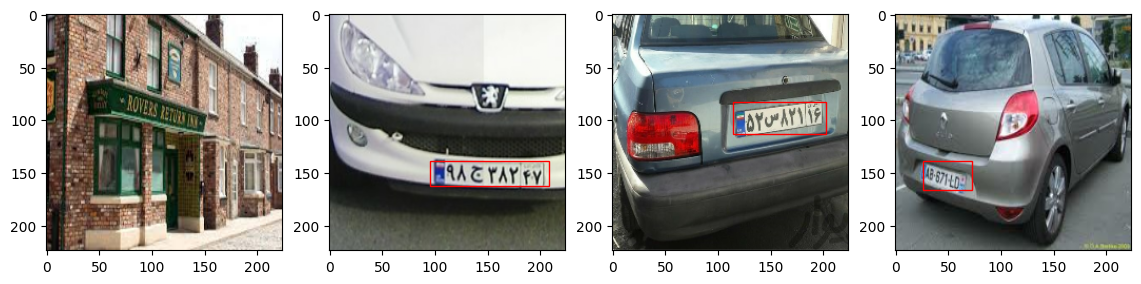

In [47]:
i__ = next(iterator__)
fig, ax = plt.subplots(1,NUM_PICS,figsize=(14,14))

for idx, img in enumerate(i__[0]):
  label = model.predict(tf.expand_dims(img, 0))
  if tf.round(label[0][0]):
    print(label[0][0])
    rect = plt.Rectangle((label[0][1] * 224 ,label[0][2]*224), label[0][3]*224,label[0][4]*224,
                          linewidth = 1,
                          edgecolor = 'r', 
                          facecolor = 'none')
    ax[idx].imshow(img)
    ax[idx].add_patch(rect)
  else:
    print(label[0][0])
    ax[idx].imshow(img)

  if idx == NUM_PICS-1:
    break

In [49]:
def crop_plate(image, label, resize_to):
  ''' This function recieves an image and the predicted labeled that is calculated passing through the trained model
  and if there is a plate inside the image based on the predictions it crops it and resizes it to the tuple resize_to.
  resize_to is gonna be (64,128) in our case.
  image must be of three dimensions (H,W,C)
  and label is of shape (1,5)
  '''
  image_size = image.shape[0]
  label = tf.cast(label * image_size, dtype=tf.int32) # Revert back the label based on the image size
  label = label[0] # the model prediction is of shape (1,5)
  if label[0]>120:
    x_top_left = label[1]
    y_top_left = label[2]
    width = label[3]
    height = label[4]
    image = image[y_top_left:y_top_left+height,x_top_left:x_top_left+width,:]
    image = tf.image.resize(image, resize_to)
    return image




In [ ]:
plate_only_images = []
for image,_ in train_data: # _ is the corresponding label.
  label = model.predict(tf.expand_dims(image,0))
  label = tf.cast(label * 224, dtype=tf.int32)
  label = label[0]
  if label[0]>120:
    x_top_left = label[1]
    y_top_left = label[2]
    width = label[3]
    height = label[4]
    image = image[y_top_left:y_top_left+height,x_top_left:x_top_left+width,:]
    image = tf.image.resize(image, (64,128))
    plate_only_images.append(image)

1/1 [==============================] - 0s 60ms/step


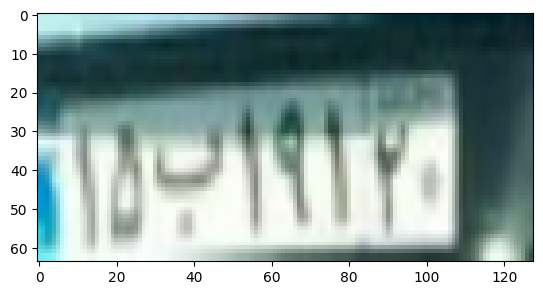

In [ ]:
plt.imshow(plate_only_images[12])